# RO47019: Intelligent Control Systems Practical Assignment
* Period: 2022-2023, Q3
* Course homepage: https://brightspace.tudelft.nl/d2l/home/500969
* Instructor: Cosimo Della Santina (C.DellaSantina@tudelft.nl)
* Teaching assistant: Ruben Martin Rodriguez (R.MartinRodriguez@student.tudelft.nl)
* (c) TU Delft, 2023

Make sure you fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE`. Remove `raise NotImplementedError()` afterwards. Moreover, if you see an empty cell, please DO NOT delete it, instead run that cell as you would run all other cells. Please fill in your name(s) and other required details below:

In [1]:
# Please fill in your names, student numbers, netID, and emails below.
STUDENT_1_NAME = "Jasper Boogers"
STUDENT_1_STUDENT_NUMBER = "4591704"
STUDENT_1_NETID = "jboogers"
STUDENT_1_EMAIL = "j.m.boogers@student.tudelft.nl"

In [2]:
# Note: this block is a check that you have filled in the above information.
# It will throw an AssertionError until all fields are filled
assert STUDENT_1_NAME != ""
assert STUDENT_1_STUDENT_NUMBER != ""
assert STUDENT_1_NETID != ""
assert STUDENT_1_EMAIL != ""

### General announcements

* Do *not* share your solutions, and do *not* copy solutions from others. By submitting your solutions, you claim that you alone are responsible for this code.

* Do *not* email questions directly, since we want to provide everybody with the same information and avoid repeating the same answers. Instead, please post your questions regarding this assignment in the correct support forum on Brightspace, this way everybody can benefit from the response. If you do have a particular question that you want to ask directly, please use the scheduled Q&A hours to ask the TA.

* There is a strict deadline for each assignment. Students are responsible to ensure that they have uploaded their work in time. So, please double check that your upload succeeded to the Brightspace and avoid any late penalties.

* This [Jupyter notebook](https://jupyter.org/) uses `nbgrader` to help us with automated tests. `nbgrader` will make various cells in this notebook "uneditable" or "unremovable" and gives them a special id in the cell metadata. This way, when we run our checks, the system will check the existence of the cell ids and verify the number of points and which checks must be run. While there are ways that you can edit the metadata and work around the restrictions to delete or modify these special cells, you should not do that since then our nbgrader backend will not be able to parse your notebook and give you points for the assignment. You are free to add additional cells, but if you find a cell that you cannot modify or remove, please know that this is on purpose.

* This notebook will have in various places a line that throws a `NotImplementedError` exception. These are locations where the assignment requires you to adapt the code! These lines are just there as a reminder for youthat you have not yet adapted that particular piece of code, especially when you execute all the cells. Once your solution code replaced these lines, it should accordingly *not* throw any exceptions anymore.

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

# Task 2c.4 - Rollout of the learned dynamics (15p)

**Author:** Maximilian Stölzle (M.W.Stolzle@tudelft.nl)

The goal of this task is to verify the accuracy of the learned dynamics. Namely, we will compare how well the learned dynamics match the nominal dynamics. We do this by initializing both the nominal and the learned dynamics at the same initial conditions (e.g. $\theta(0)$ and $\dot{\theta}(0)$) and let both dynamics naturally evolve for 10s without applying any external torque to the links. We can then compute error metrics between the trajectory of the nominal and the learned system.

If you correctly implement this task, you will receive a baseline of 3 points. The remaining 12 points are distributed based on the prediction performance of your trained Lagrangian neural network. You will receive full points for this task if the Euclidean norm of the RMSE of the end-effector position between the nominal and the learned dynamics is **below** 0.10 m. If the error is between 0.10 m and 3.00 m, your grade will be linarly scaled with the error. However, if the error is larger than 3.00 m, you will not receive any credits for the performance of the Lagrangian neural network.

In [1]:
# Reloads the python files outside of this notebook automatically
%load_ext autoreload
%autoreload 2

# import all Python modules
import dill
from distutils.util import strtobool
from functools import partial
from IPython.display import display, HTML  # For animations in the notebook
from jax.config import config as jax_config

jax_config.update("jax_platform_name", "cpu")  # set default device to 'cpu'
jax_config.update("jax_enable_x64", True)  # double precision
from jax import jit, lax, random
from jax import numpy as jnp
from matplotlib import rcParams
import matplotlib.pyplot as plt
import os
from pathlib import Path
from progressbar import progressbar
from typing import Dict, Tuple

from jax_double_pendulum.analysis import *
from jax_double_pendulum.robot_parameters import ROBOT_PARAMS
from jax_double_pendulum.robot_simulation import simulate_robot
from jax_double_pendulum.visualization import animate_robot

from lnn_analysis import (
    plot_rollout_learned_dynamics_configuration_space,
    plot_rollout_learned_dynamics_operational_space,
)

# define boolean to check if the notebook is run for the purposes of autograding
AUTOGRADING = strtobool(os.environ.get("AUTOGRADING", "false"))

In [7]:
# simulation parameters
sim_duration = 8.0  # [s]
sim_dt = 1e-2  # [s]

# define initial condition
th_0 = jnp.array([0, 0])  # [rad]
th_d_0 = jnp.array([0, 0])  # [rad/s]

# define time steps
t_ts = sim_dt * jnp.arange(int(sim_duration / sim_dt))

# define folder where to save animations and plots
outputs_dir = Path("outputs")
outputs_dir.mkdir(parents=True, exist_ok=True)

# simulate the nominal (i.e. first-principle) dynamics
nominal_sim_ts = simulate_robot(
    rp=ROBOT_PARAMS,
    t_ts=t_ts,
    th_0=th_0,
    th_d_0=th_d_0,
)

In [8]:
# load the save neural network params
statedict_path = str(Path("statedicts") / "task_2c_lagrangian_nn_params.pkl")
with open(statedict_path, "rb") as f:
    nn_params = dill.load(f)

# import the learned discrete forward dynamics from lagrangian_nn.ipynb
from ipynb.fs.full.lnn import discrete_forward_dynamics as lnn_discrete_forward_dynamics

# transform lnn_discrete_forward_dynamics to behave to the following signature
# th_next, th_d_next, th_dd = discrete_forward_dynamics(dt, th_curr, th_d_curr, tau)
learned_discrete_forward_dynamics_fn = partial(lnn_discrete_forward_dynamics,
                                               nn_params["MassMatrixNN"]["params"],
                                               nn_params["PotentialEnergyNN"]["params"])
# YOUR CODE HERE

# simulate the learned dynamics
# Hint: pass the `learned_discrete_forward_dynamics_fn` to the `simulate_robot` function.
learned_sim_ts = simulate_robot(rp=ROBOT_PARAMS,
                                discrete_forward_dynamics_fn=learned_discrete_forward_dynamics_fn,
                                t_ts=t_ts,
                                th_0=th_0,
                                th_d_0=th_d_0)
# YOUR CODE HERE

rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(
    nominal_sim_ts, learned_sim_ts
)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(
    nominal_sim_ts, learned_sim_ts
)
with jnp.printoptions(precision=3):
    print(
        "RMSE theta:",
        rmse_th,
        "rad, RMSE theta_d:",
        rmse_th_d,
        "rad/s, RMSE theta_dd:",
        rmse_th_dd,
        "rad/s^2",
    )
    print(
        "RMSE x:",
        f"{jnp.linalg.norm(rmse_x):.4f}",
        "m, RMSE x_d:",
        f"{jnp.linalg.norm(rmse_x_d):.3f}",
        "m/s, RMSE x_dd:",
        f"{jnp.linalg.norm(rmse_x_dd):.2f}",
        "m/s^2",
    )

RMSE theta: [0.019 0.101] rad, RMSE theta_d: [0.094 0.363] rad/s, RMSE theta_dd: [0.792 1.603] rad/s^2
RMSE x: 0.0878 m, RMSE x_d: 0.409 m/s, RMSE x_dd: 4.33 m/s^2


In [9]:
# DO NOT REMOVE OR MODIFY THIS CELL

rmse_th, rmse_th_d, rmse_th_dd = compute_configuration_space_rmse(
    nominal_sim_ts, learned_sim_ts
)
rmse_x, rmse_x_d, rmse_x_dd = compute_operational_space_rmse(
    nominal_sim_ts, learned_sim_ts
)

grader_max_impl_points = 3  # points for a correct implementation
grader_max_perf_points = 12  # points for a good prediction performance

rmse_x_norm = jnp.linalg.norm(rmse_x)  # achieved RMSE in operational space
rmse_x_lb = 0.10  # m --> this will result in the full grade
rmse_x_ub = 3.00  # m --> this will result in zero points for the prediction performance

grader_perf_points = grader_max_perf_points * (
    (1 - (rmse_x_norm - rmse_x_lb) / (rmse_x_ub - rmse_x_lb))
)
grader_perf_points = jnp.clip(grader_perf_points, 0, grader_max_perf_points).item()

grader_points = grader_max_impl_points + grader_perf_points

print(
    f"If you submit the assignment as it is, you will receive {grader_points} points."
)


If you submit the assignment as it is, you will receive 15.0 points.


15.0

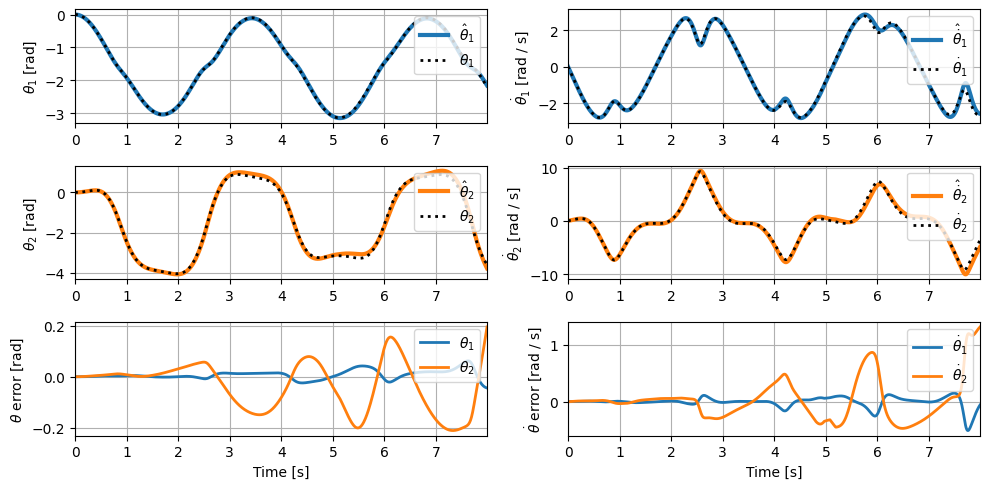

In [11]:
# compare the learned against the nominal dynamics rollout in configuration space
plot_rollout_learned_dynamics_configuration_space(
    nominal_sim_ts,
    learned_sim_ts,
    filepath=str(
        outputs_dir / "task_2c-4_rollout_learned_dynamics_configuration_space.pdf"
    ),
)

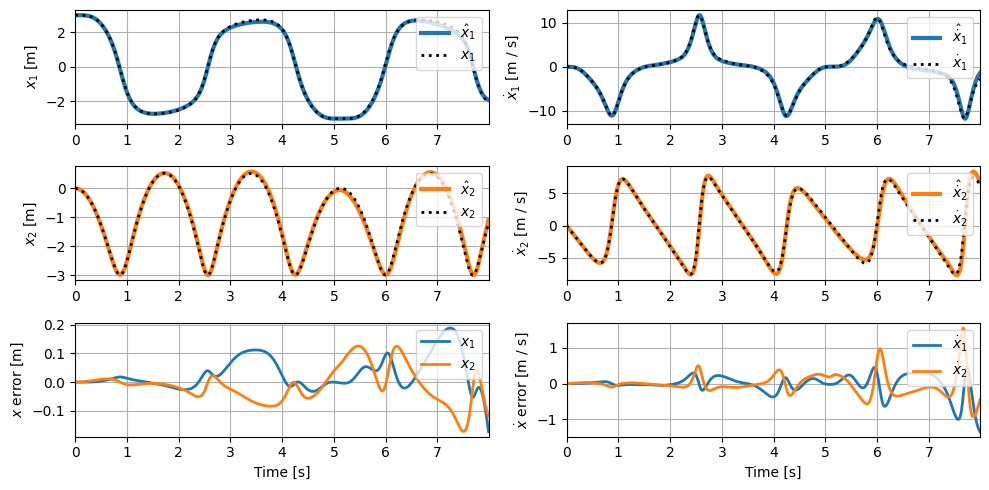

In [12]:
# compare the learned against the nominal dynamics rollout in operational space
plot_rollout_learned_dynamics_operational_space(
    nominal_sim_ts,
    learned_sim_ts,
    filepath=str(
        outputs_dir / "task_2c-4_rollout_learned_dynamics_operational_space.pdf"
    ),
)

In [13]:
if not AUTOGRADING:
    # animate the robot for both the learned and the nominal dynamics
    # the nominal dynamics are plotted as "End-effector trajectory" and "Robot state"
    # the learned dynamics are plotted as "Est. end-effector traj." and "Estimated robot state"
    ani = animate_robot(
        ROBOT_PARAMS,
        sim_ts=nominal_sim_ts,
        sim_hat_ts=learned_sim_ts,
        step_skip=5,
        show=False,
        filepath=str(outputs_dir / "task_2c-4_rollout_learned_dynamics.mp4"),
    )
    display(HTML(ani.to_html5_video()))